# 2020 Covid dataset analysed


## Part 1 - Feature Engineering 

In [111]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from datetime import datetime
from tensorflow import keras

In [112]:
list_of_df= []
for (root, dirs, files) in os.walk(os.path.join(os.getcwd(), "county_data")):
    for file in files:
        if file[-4:] == ".csv": 
            df = pd.read_csv(os.path.join(root, file))
            df = df.dropna()
            if len(df):
                name = df["areaName"][5]
                df = df.drop(df.columns[:3], axis=1)[::-1].reset_index(drop=True)
                df['y'] = df["newCasesBySpecimenDate"]/df["newVirusTestsBySpecimenDate"]
                df.columns=['Date','Cases','Deaths','Tests','y']
                df=df.set_index('Date')
                list_of_df.append([name,df])




In [113]:
list_of_df[0][1]

,Cases,Deaths,Tests,y
Date,,,,
2020-03-20,1.0,1.0,4,0.250000
2020-03-21,0.0,1.0,5,0.000000
2020-03-22,0.0,0.0,9,0.000000
2020-03-23,0.0,0.0,11,0.000000
2020-03-24,0.0,0.0,11,0.000000
...,...,...,...,...
2022-11-10,11.0,0.0,66,0.166667
2022-11-11,0.0,0.0,45,0.000000
2022-11-12,5.0,0.0,176,0.028409


Now we have to set the target of the analysis. For a certain country, train a model that is trained on its 2020-01 -- 2020-05 dataset such that time is the input and the outputs are #of new cases. It will be tested on 2020-06 -- 2020-07 dataset.

In [116]:
list_of_features=['Cases','Deaths','Tests']
list_county=[x[0] for x in list_of_df]

def norm_feature(data,col=None):
    '''
    Given a DataFrame and a column, it normalises the data in a new column called NORM_column
    '''
    if col is None:
        a=(data-data.mean())/data.std()
    else: 
        a=(data[col]-data[col].mean())/data[col].std()
    name='NORM_'+ col
    data[name]=a
    return data

def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

features=[]
for name,df in list_of_df:
    for feature in list_of_features:
        a='NORM_'+feature
        if a not in features:
            features.append(a)
        if a not in df.columns:
            df = norm_feature(df, col=feature)


In [119]:
list_of_df[0][1].describe()

,Cases,Deaths,Tests,y,NORM_Cases,NORM_Deaths,NORM_Tests
count,970.000000,970.000000,970.000000,970.000000,9.700000e+02,9.700000e+02,9.700000e+02
mean,37.091753,0.380412,806.815464,0.067686,1.602384e-18,-2.283740e-15,2.815617e-17
std,61.640514,0.844229,743.090305,0.114433,1.000000e+00,1.000000e+00,1.000000e+00
min,0.000000,0.000000,4.000000,0.000000,-6.017431e-01,-4.506034e-01,-1.080374e+00
25%,6.000000,0.000000,167.250000,0.021164,-5.044045e-01,-4.506034e-01,-8.606834e-01
50%,20.000000,0.000000,560.500000,0.042134,-2.772811e-01,-4.506034e-01,-3.314745e-01
75%,45.000000,0.000000,1324.500000,0.076801,1.282963e-01,-4.506034e-01,6.966644e-01
max,839.000000,10.000000,3686.000000,2.000000,1.300943e+01,1.139453e+01,3.874609e+00


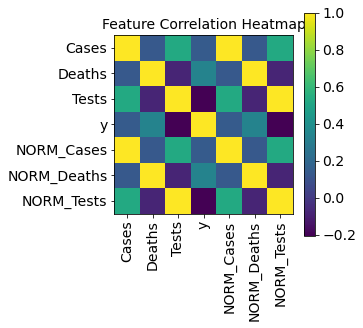

In [120]:
import matplotlib.pyplot as plt
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()

show_heatmap(list_of_df[0][1])

In [59]:
ratio= 0.715
train_split = int( ratio * int(df.shape[0]))
def build_data(df,features,c): 
    '''
    Given a country c,the DataFrame, and a list of features, it returns a tuple of x_train, x_test, y_train, y_test
    '''
    
    a=df.loc[df.Country==c]
    a.set_index('Date')

    df_train=a.loc[:train_split]
    df_test=a.drop(df_train.index)

    X_train=pd.DataFrame(df_train.loc[:,features])
    X_test=pd.DataFrame(df_test.loc[:,features])
    y_train=pd.DataFrame(df_train['New cases'])
    y_test=pd.DataFrame(df_test['New cases'])
    return X_train, X_test, y_train, y_test, df_train, df_test


def build_data_world(df,features,cs):
    '''
    Given a list of countries c,the DataFrame, and a list of features, it returns a tuple of x_train, x_test, y_train, y_test
    '''
    X_train, X_test, y_train, y_test=None,None,None,None
    for c in cs:
        a=df.loc[df.Country==c]
        df_train=a.loc[a['NORM_delta_t']<2*ratio]
        df_test=a.drop(df_train.index)
        if X_train is None or X_test is None or y_train is None or y_test is None:
            X_train=tf.convert_to_tensor(df_train.loc[:,features])
            X_test=tf.convert_to_tensor(df_test.loc[:,features])
            y_train=tf.convert_to_tensor(df_train['New cases'])
            y_test=tf.convert_to_tensor(df_test['New cases'])
        else:
            X_train=tf.add(tf.convert_to_tensor(df_train.loc[:,features]),X_train)
            X_test=tf.add(tf.convert_to_tensor(df_test.loc[:,features]),X_test)
            y_train=tf.add(tf.convert_to_tensor(df_train['New cases']),y_train)
            y_test=tf.add(tf.convert_to_tensor(df_test['New cases']),y_test)
    return X_train, X_test, y_train, y_test, df_train, df_test
       
    
X_train, X_test, y_train, y_test, df_train, df_test= build_data(df=df,features=features,c='Italy')

    

In [60]:
assert(X_train.shape[0]==y_train.shape[0])
assert(X_test.shape[0]==y_test.shape[0])


Now everything is ready to train our model.

## Part 2 - Deep Learning 

In [61]:
step = 6
past = 80
future = 30
learning_rate = 0.001
batch_size = 10
epochs = 294

In [62]:
start = past + future
end = start + train_split
sequence_length = int(past / step)

In [63]:
X_train.shape

(134, 4)

In [64]:
def build_model():
    model=tf.keras.Sequential([
        tf.keras.layers.Dense(units=30,input_shape=[len(features)],activation='selu'),
        tf.keras.layers.Dense(units=20,activation='selu'),
        tf.keras.layers.Dense(units=15, activation='selu'),
        tf.keras.layers.Dense(units=1),
    ])
    model.compile(
    optimizer='adam',
    loss='mae',)
    return model

dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    X_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)
        

In [65]:
x_end = len(y_test) - past - future
label_start = train_split + past + future
#########################
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    X_test,
    y_test,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)
for batch in dataset_train.take(1):
    inputs, targets = batch
print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (10, 13, 4)
Target shape: (10, 1)


In [72]:
batch_size=20
epochs=204

#model1=build_model()
#history = model1.fit(
#    X_train, y_train,
#    validation_data=(X_test, y_test),
#    batch_size=batch_size,
#    epochs=epochs,)


inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 13, 4)]           0         
                                                                 
 lstm_11 (LSTM)              (None, 32)                4736      
                                                                 
 dense_19 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4,769
Trainable params: 4,769
Non-trainable params: 0
_________________________________________________________________


In [73]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/204
6/6 [==============================] - 2s 13ms/step - loss: 1664603.2500
Epoch 2/204
6/6 [==============================] - 0s 25ms/step - loss: 1664304.2500
Epoch 3/204
6/6 [==============================] - 0s 15ms/step - loss: 1663999.7500
Epoch 4/204
6/6 [==============================] - 0s 13ms/step - loss: 1663688.7500
Epoch 5/204
6/6 [==============================] - 0s 13ms/step - loss: 1663367.5000
Epoch 6/204
6/6 [==============================] - 0s 13ms/step - loss: 1663031.1250
Epoch 7/204
6/6 [==============================] - 0s 13ms/step - loss: 1662675.3750
Epoch 8/204
6/6 [==============================] - 0s 12ms/step - loss: 1662300.3750
Epoch 9/204
6/6 [==============================] - 0s 13ms/step - loss: 1661911.0000
Epoch 10/204
6/6 [==============================] - 0s 13ms/step - loss: 1661516.3750
Epoch 11/204
6/6 [==============================] - 0s 13ms/step - loss: 1661121.5000
Epoch 12/204
6/6 [==============================] - 0s 12ms/ste

In [74]:
history.history.keys()

dict_keys(['loss'])

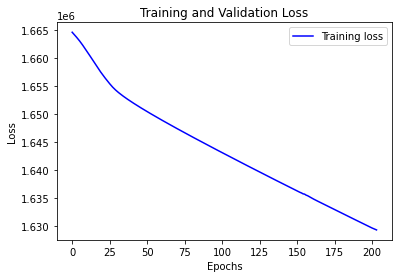

In [76]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    #val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    #plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

KeyError: 'val_loss'

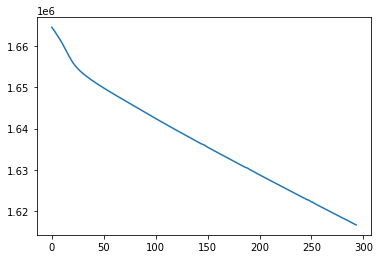

In [20]:
# convert the training history to a dataframe
history_df = pd.DataFrame(history.history)
# use Pandas native plot method
history_df['loss'].plot()
history_df['val_loss'].plot()
history_df

In [16]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )

In [ ]:
import matplotlib.pyplot as plt
t_train=[0]*X_train.shape[0]
for i in range(X_train.shape[0]):
    t_train[i]=X_train.numpy()[i][0]
t_test=[0]*X_test.shape[0]
for i in range(X_test.shape[0]):
    t_test[i]=X_test.numpy()[i][0]
y_test_predict=model.predict(X_test)
y_train_predict=model.predict(X_train)
plt.plot(t_train,y_train)
plt.plot(t_test,y_test)
plt.plot(t_test,y_test_predict)
plt.plot(t_train,y_train_predict)
plt.show()

AttributeError: 'DataFrame' object has no attribute 'numpy'